# Notebook to obtain wind effect for SODA reanalysis data using regression

In [31]:
import pandas as pd
import xarray as xr
import numpy as np
import copy

from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Import sea level and wind stress data

In [32]:
path_sl = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/regression input'
path_ws = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/wind stress'

sealevel_data = pd.read_csv(f'{path_sl}/sealevel_soda.csv', index_col = 'time')
windstress_data = pd.read_csv(f'{path_ws}/windstress.csv', index_col = 'time')

In [33]:
windstress_data.columns = [     ('Vlissingen', '$U \sqrt{u^2+v^2}$'),
            ('Vlissingen', '$V \sqrt{u^2+v^2}$'),
       ('Hoek v. Holland', '$U \sqrt{u^2+v^2}$'),
       ('Hoek v. Holland', '$V \sqrt{u^2+v^2}$'),
            ('Den Helder', '$U \sqrt{u^2+v^2}$'),
            ('Den Helder', '$V \sqrt{u^2+v^2}$'),
              ('Delfzijl', '$U \sqrt{u^2+v^2}$'),
              ('Delfzijl', '$V \sqrt{u^2+v^2}$'),
             ('Harlingen', '$U \sqrt{u^2+v^2}$'),
             ('Harlingen', '$V \sqrt{u^2+v^2}$'),
              ('IJmuiden', '$U \sqrt{u^2+v^2}$'),
              ('IJmuiden', '$V \sqrt{u^2+v^2}$'),
               ('Average', '$U \sqrt{u^2+v^2}$'),
               ('Average', '$V \sqrt{u^2+v^2}$')]

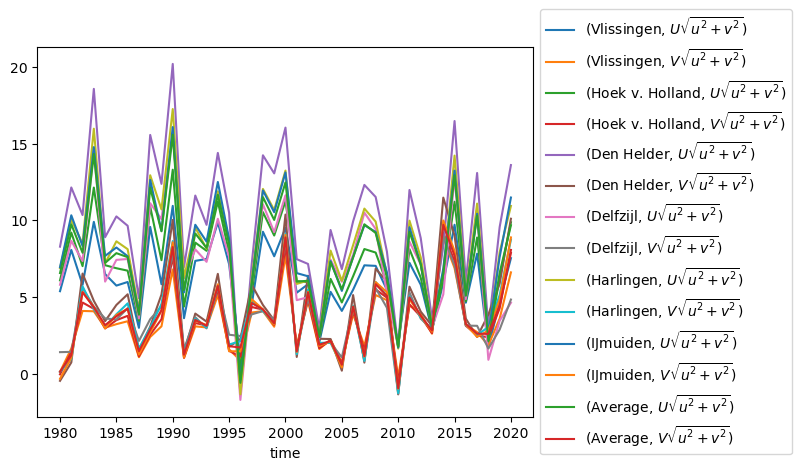

In [34]:
windstress_data.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

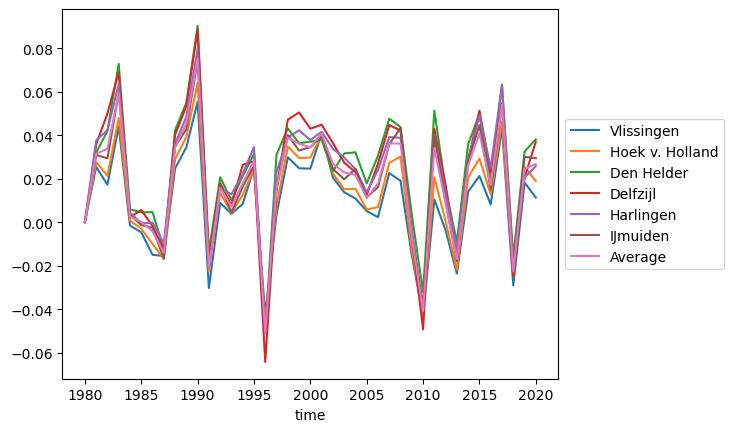

In [35]:
sealevel_data.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Perform regression

In [36]:
stations = sealevel_data.columns
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/regression output'

def regression(sea_data, wind_data):
    """
    Function to perform the regression with sea-level and wind-stress data to obtain the wind effect on 
    sea level along the Dutch coast.
    
    """
    
    # Obtain trend timeseries to add to dataframe later
    trend = wind_data.index - wind_data.index[0]
    
    
    # Obtain nodal timeseries to add to dataframe later
    nodal1 = np.cos(2*np.pi*trend/18.613)
    nodal2 = np.sin(2*np.pi*trend/18.613)
    
    # Create lists containing names of regression terms
    regg_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$', 'trend', 'nodal1', 'nodal2']
    wind_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    
    
    # Create lists to save datasets
    timeseries_lst = []
    netcdf_lst = []
    reg_results_lst = []
    coef_lst = []
    intercept_lst = []
    rmse_lst = []
    R2_total_lst = []
    R2_wind_lst = []
    R2_u2_lst = []
    R2_v2_lst = []
    
    # Perform regression for each station
    for station in stations:
        
        # Create dataframe for y 
        y = sea_data[station]
    
        # Create dataframe for x
        x = pd.DataFrame(data={'time': wind_data.index,
                              '$U \sqrt{u^2+v^2}$': wind_data[station, '$U \sqrt{u^2+v^2}$'],
                              '$V \sqrt{u^2+v^2}$': wind_data[station, '$V \sqrt{u^2+v^2}$'],
                              'trend': trend,
                              'nodal1': nodal1,
                              'nodal2': nodal2})
        
        x = x.set_index('time')
        
        # Define regression
        regression_ = linr()
        
        
        # Interpolate to remove nan values
        x = x.interpolate(axis=0)
        y = y.interpolate(axis=0)
        
        
        # Standardize x
        scaler = StandardScaler()
        x = copy.deepcopy(x)
        x.iloc[:,:] = scaler.fit_transform(x)
        
        
        # Create copy such that regression result can be obtained for full timeseries
        x_timeseries = copy.deepcopy(x)
        
        
        # Create dataframes of equal time span
        y = y[y.index.isin(x.index)]
        x = x[x.index.isin(y.index)]
        
        
        # Fit the regression model and add results to lists
        fit = regression_.fit(x,y)
        score = regression_.score(x,y) # R^2 for the whole regression including the trend and nodal fit 
        intercept_lst.append(regression_.intercept_)
        coef_lst.append(regression_.coef_.tolist())
        
        
        # Calculate rmse
        yhat = regression_.predict(x)
        mse = mean_squared_error(y, yhat) # Calculate insample mse
        rmse_lst.append(np.sqrt(mse))
        
        
        # Obtain dataframe containing timeseries resulting from regression
        df = pd.DataFrame(data=dict(time=x_timeseries.index))
        df = df.set_index('time')
        
        for i in range(len(regg_names)):
            df[regg_names[i]] = coef_lst[-1][i] * x_timeseries[x_timeseries.columns[i]]
            
        df['total'] = df.sum(axis=1)
        df['wind total'] = df[wind_names].sum(axis=1)
        
        # Add dataframe to list 
        timeseries_lst.append(df)
        
        netcdf_lst.append(xr.Dataset(data_vars=dict(u2=(['time'],  df['$U \sqrt{u^2+v^2}$'].values),
                                                    v2=(['time'],  df['$V \sqrt{u^2+v^2}$'].values),
                                                    trend=(['time'],  df['trend'].values),
                                                    nodal1=(['time'],  df['nodal1'].values),
                                                    nodal2=(['time'],  df['nodal2'].values),
                                                    total=(['time'],  df['total'].values),
                                                    wind_total=(['time'],  df['wind total'].values),
                                                    time = df.index.values)))
        
        # Calculate R^2 values
        R2_total_lst.append(score) # R^2 for the whole regression including the trend
        R2_wind_lst.append(R2_var(df, y, 'wind total', regression_))
        R2_u2_lst.append(R2_var(df, y, '$U \sqrt{u^2+v^2}$', regression_))
        R2_v2_lst.append(R2_var(df, y, '$V \sqrt{u^2+v^2}$', regression_))
                

            
    # Create dataframe of timeseries
    timeseries_df = pd.concat(timeseries_lst, axis=1, keys = stations)      
    timeseries_nc = xr.concat(netcdf_lst, dim=stations).rename({"concat_dim":"station"})       
    
    # Save netcdf file
    timeseries_nc.to_netcdf(f'{path}/timeseries_soda.nc')
    
    
    
    # Create dataframe of coefficients
    
    # Transpose coef list
    numpy_array = np.array(coef_lst)
    transpose = numpy_array.T
    coef_lst_T = transpose.tolist()
    
    results_df = pd.DataFrame(data={'station': stations, 
                                    'R$^2$' : R2_total_lst,
                                    'R$^2_{wind}$' : R2_wind_lst,
                                    'R$^2_{U \sqrt{u^2+v^2}}$' : R2_u2_lst,
                                    'R$^2_{V \sqrt{u^2+v^2}}$' : R2_v2_lst,
                                    'RMSE': rmse_lst, 
                                    'constant' : intercept_lst})
    
    
    
    for i in range(len(coef_lst_T)):
        results_df[regg_names[i]] = coef_lst_T[i]
        
    results_df = results_df.set_index('station')
     
        
    results_nc = xr.Dataset(data_vars=dict(r2=(['station'], R2_total_lst),
                                                        r2_wind=(['station'], R2_wind_lst),
                                                        r2_u2=(['station'], R2_u2_lst),
                                                        r2_v2=(['station'], R2_v2_lst),
                                                        rmse=(['station'], rmse_lst),
                                                        constant=(['station'], intercept_lst),
                                                        u2=(['station'], coef_lst_T[0]),
                                                        v2=(['station'], coef_lst_T[1]),
                                                        trend=(['station'], coef_lst_T[2]),
                                                        nodal1=(['station'], coef_lst_T[3]),
                                                        nodal2=(['station'], coef_lst_T[4]),
                                                        station = stations))
    
    
    # Save netcdf file
    results_nc.to_netcdf(f'{path}/results_soda.nc')
    
    
    return(results_df, timeseries_df)


    
    
def R2_var(df, y, var, regression_):
    """
    Function to obtain R-squared for a specific variable
    
    For var choose  ['wind total', '$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    """
    
    x = pd.DataFrame(data={'time': df.index.values, 
                                var : df[var].values})
    x = x.set_index('time')
    x = x[x.index.isin(y.index)]
    
    fit = regression_.fit(x, y)
    score = regression_.score(x,y)
    
    return score


In [37]:
results, timeseries = regression(sealevel_data, windstress_data)

In [38]:
results

,R$^2$,R$^2_{wind}$,R$^2_{U \sqrt{u^2+v^2}}$,R$^2_{V \sqrt{u^2+v^2}}$,RMSE,constant,$U \sqrt{u^2+v^2}$,$V \sqrt{u^2+v^2}$,trend,nodal1,nodal2
station,,,,,,,,,,,
Vlissingen,0.646836,0.545235,0.547379,0.164067,0.013300,0.008967,0.018711,-0.002173,0.003511,0.002914,0.006079
Hoek v. Holland,0.684242,0.607408,0.612057,0.201325,0.013262,0.012721,0.020228,-0.001706,0.004539,0.002195,0.005055
Den Helder,0.729970,0.670709,0.671957,0.200621,0.014182,0.024822,0.023483,-0.000321,0.006136,0.000763,0.004176
Delfzijl,0.779932,0.665548,0.646567,0.275965,0.014090,0.022459,0.024669,0.003798,0.006471,0.004793,0.007429
Harlingen,0.697923,0.636524,0.638830,0.187913,0.014676,0.021797,0.022501,-0.000694,0.004437,0.003717,0.003670
IJmuiden,0.732334,0.655360,0.659999,0.223074,0.013283,0.018362,0.022504,-0.001123,0.006205,0.001569,0.004646
Average,0.734070,0.658172,0.659992,0.215236,0.013241,0.018188,0.022153,-0.000501,0.005125,0.002698,0.005010


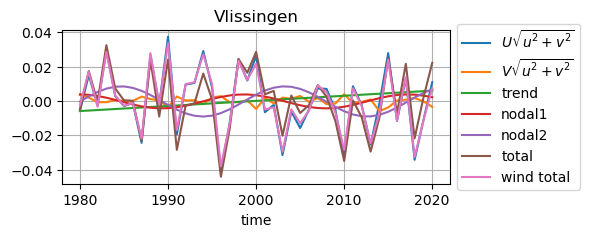

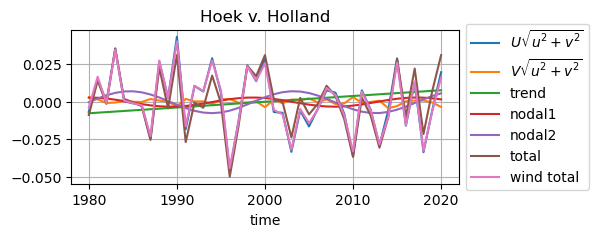

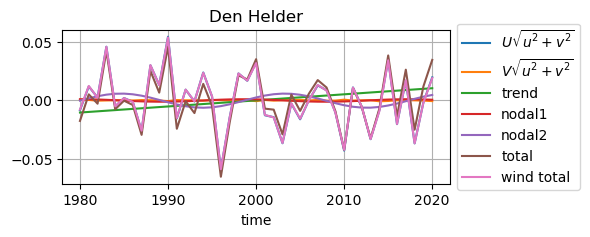

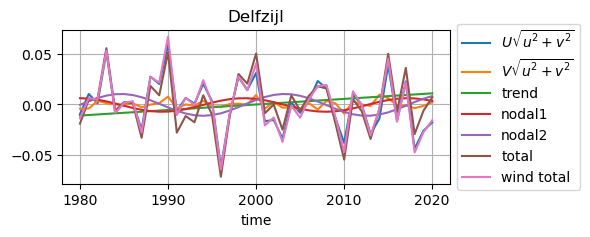

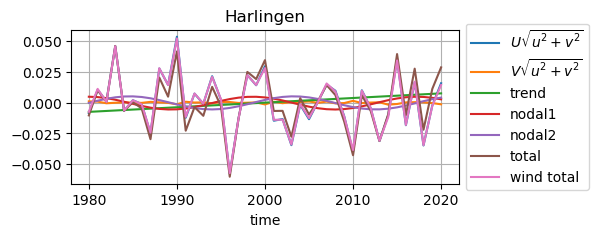

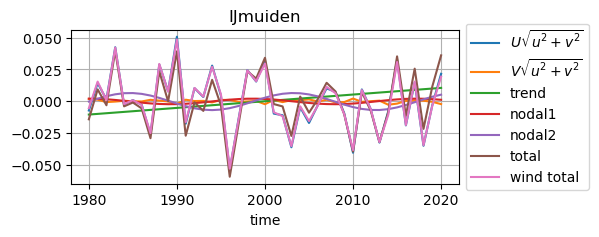

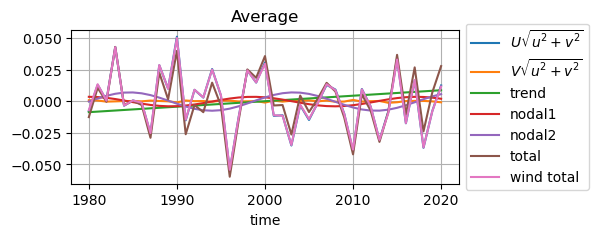

In [39]:
for station in stations:
    timeseries[station].plot(figsize=(5, 2))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(station)
    plt.xticks([1980, 1990, 2000, 2010, 2020])
    plt.grid()

In [40]:
def plot_timeseries(sea_data, timeseries, var):
    """
    Function to make a plot of the SODA sea level timeseries and regression result for each station
    For var choose a list consisting of ['u$^2$', 'v$^2$', 'trend', 'nodal1', 'nodal2', 'total', 'wind total']
    
    """
    
    
    fig, axs = plt.subplots(4, 2, figsize=(10, 8))


    for i in range(4):


        ax = axs[i,0]
        ax.plot(sea_data.index.values, sea_data[stations[2*i]].values*100, color='darkgray')
        for variab in var:
            ax.plot(timeseries.index.values, timeseries[stations[2*i], variab].values*100)
        ax.set_title(stations[2*i], fontsize = 14)
        ax.set_xlabel('Time [yr]', fontsize = 12)
        ax.set_ylabel('Sea level [cm]', fontsize = 12)
        ax.set_ylim(-8, 10)
        plt.tight_layout()


        ax = axs[i,1]
        if i == 3:
            fig.delaxes(axs[3,1])
        else:

            ax.plot(sea_data.index.values, sea_data[stations[2*i+1]].values*100, color='darkgray')
            for variab in var:
                ax.plot(timeseries.index.values, timeseries[stations[2*i], variab].values*100)
            ax.set_title(stations[2*i+1], fontsize = 14)
            ax.set_xlabel('Time [yr]', fontsize = 12)
            ax.set_ylabel('Sea level [cm]', fontsize = 12)
            ax.set_ylim(-8, 10)
            plt.tight_layout()
    
    
    labels=['SODA3.4.2']+var
    fig.legend(labels=labels, loc=(0.57, 0.1))
    

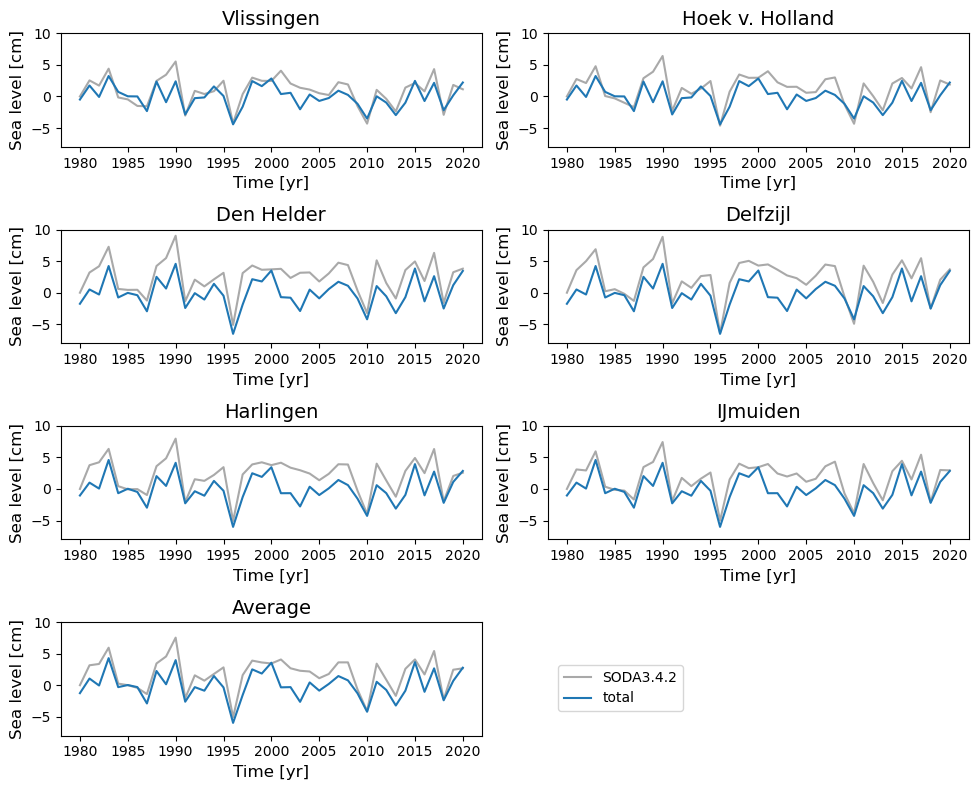

In [41]:
plot_timeseries(sealevel_data, timeseries, ['total'])

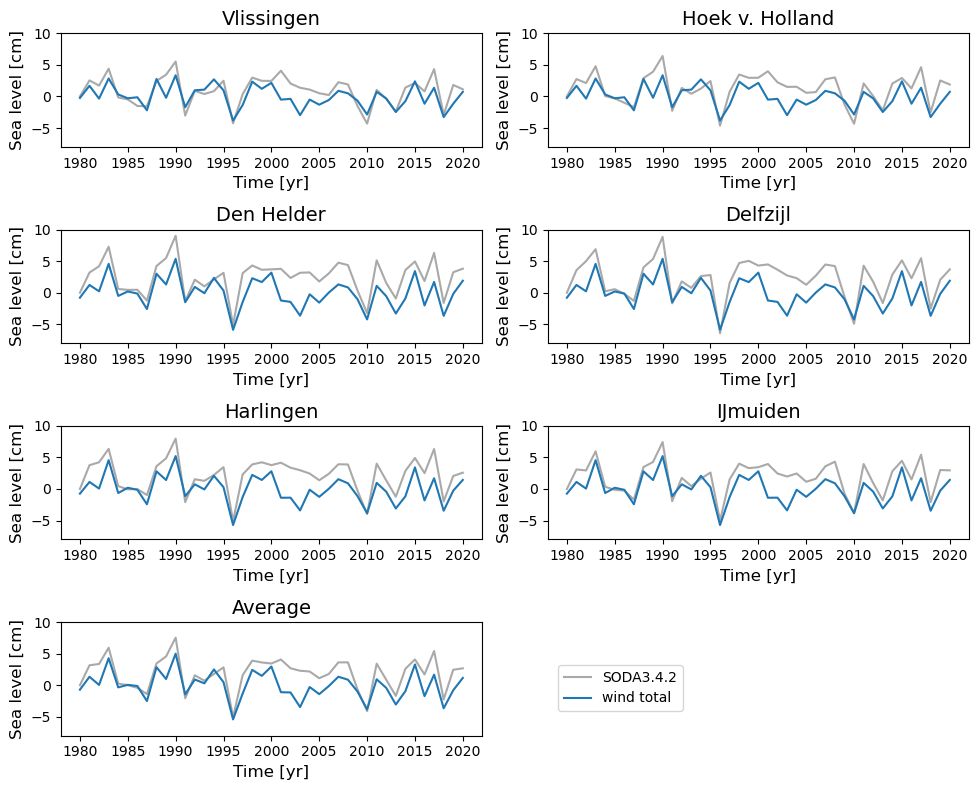

In [42]:
plot_timeseries(sealevel_data, timeseries, ['wind total'])

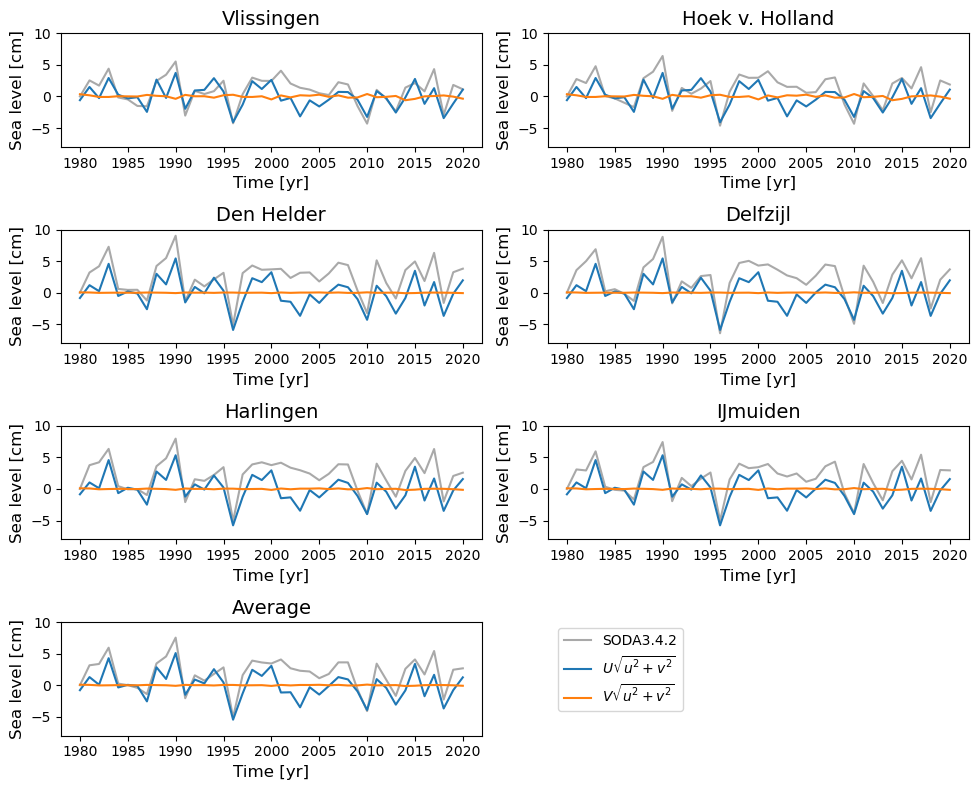

In [43]:
plot_timeseries(sealevel_data, timeseries, ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$'])

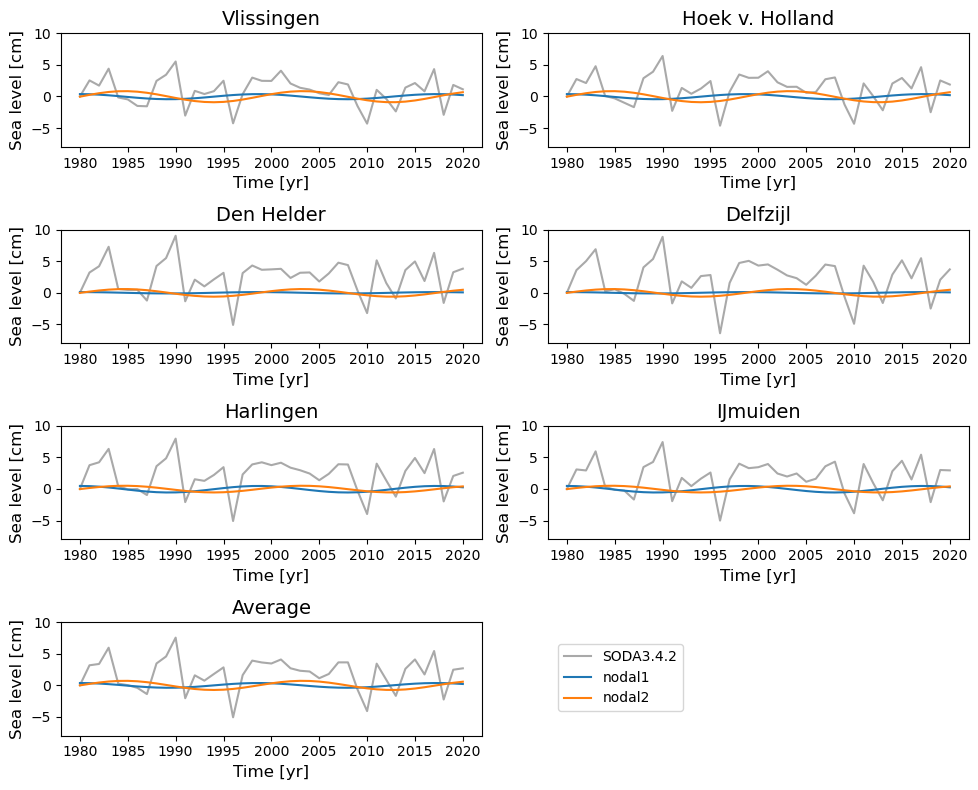

In [44]:
plot_timeseries(sealevel_data, timeseries, ['nodal1', 'nodal2'])